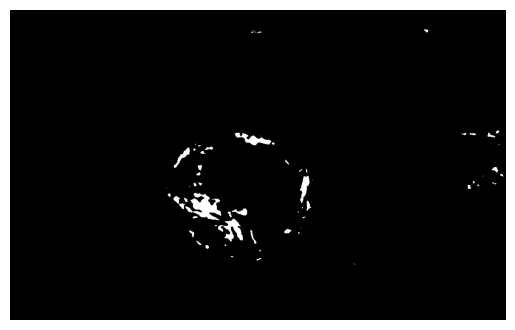

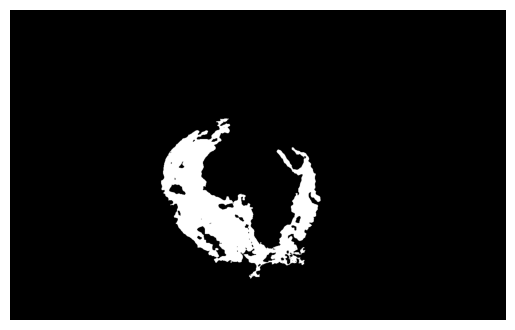

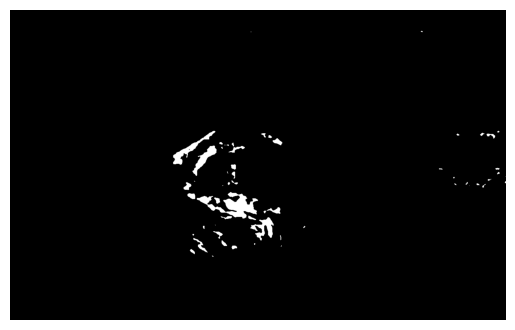

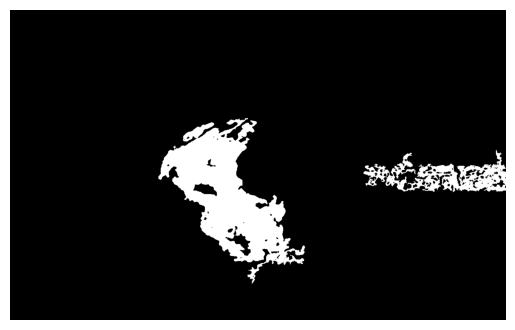

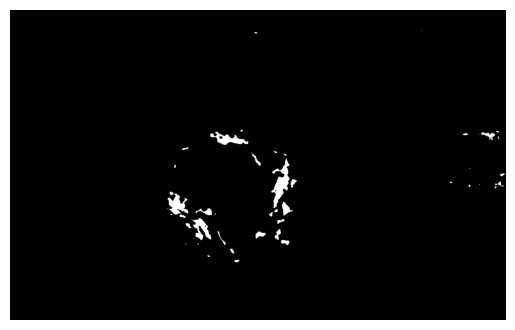

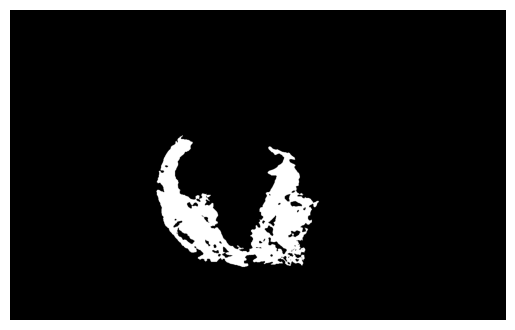

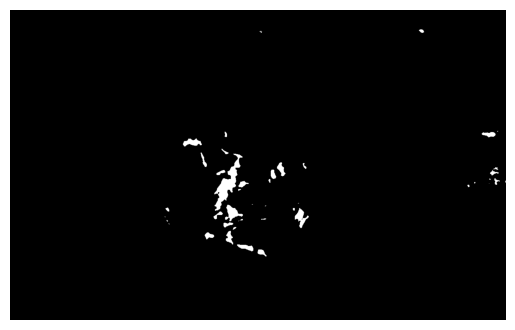

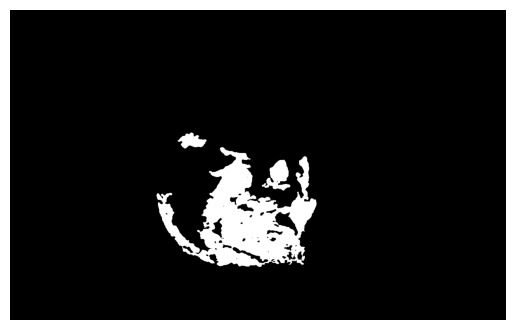

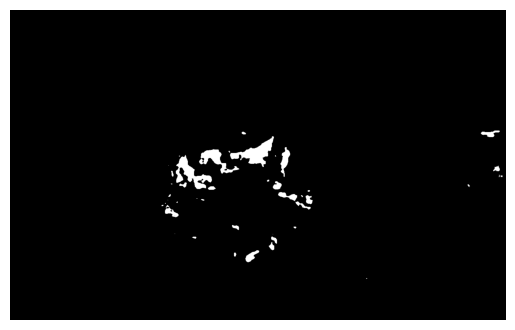

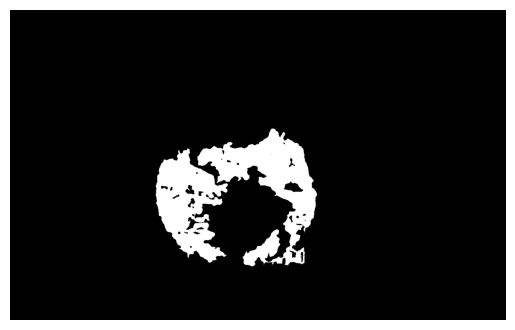

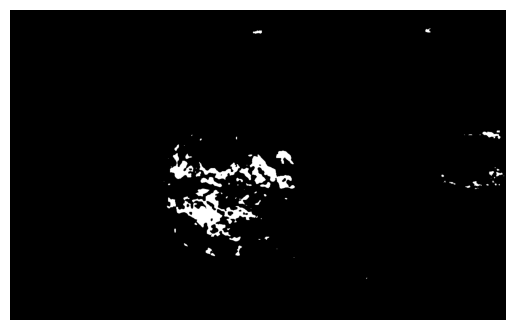

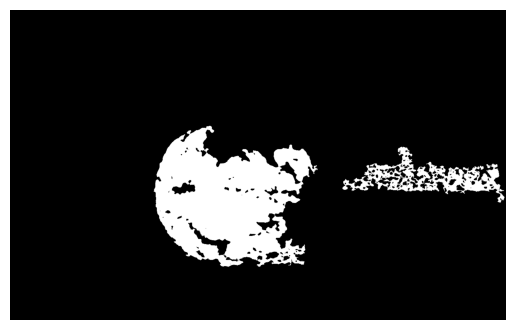

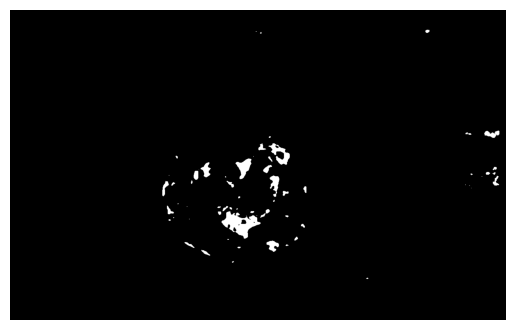

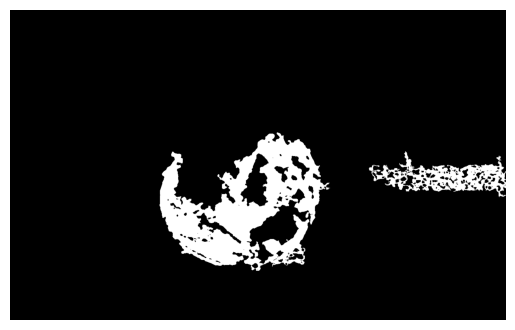

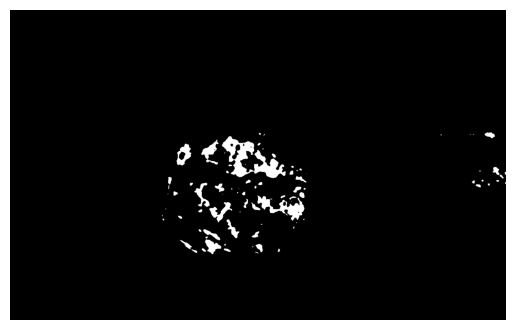

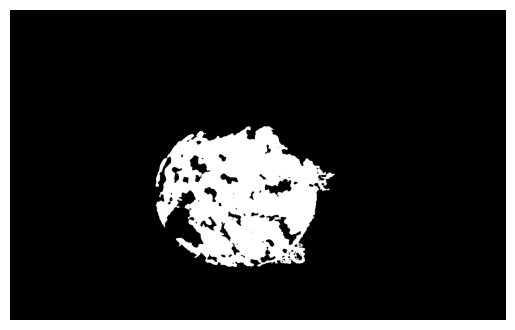

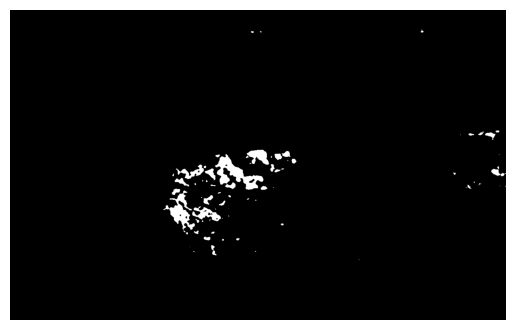

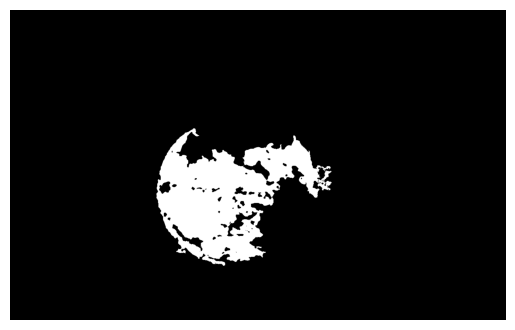

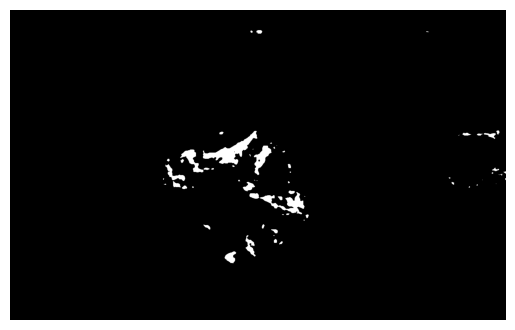

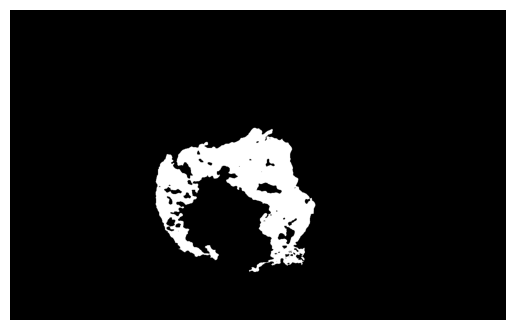

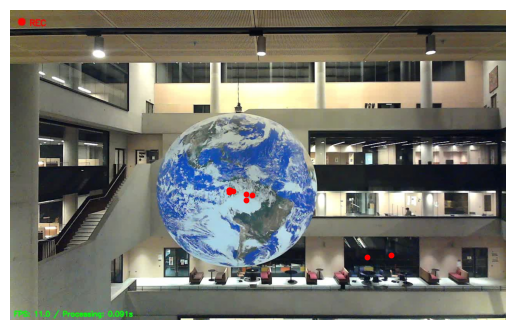

In [24]:
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import deque
import cv2
import os



def threshoding(hsv_image: Image.Image, hue_threshold: list, saturation_threshold: int = 0) -> np.ndarray:
    hsv_image_copy = hsv_image.copy()
    hsv_array = np.array(hsv_image_copy)

    hue_channel = hsv_array[:, :, 0]
    saturation_channel = hsv_array[:, :, 1]
    mask = (hue_channel >= hue_threshold[0]) & (hue_channel <= hue_threshold[1]) & (saturation_channel >= saturation_threshold)
    binary_image = np.zeros_like(hue_channel)
    binary_image[mask] = 255

    return binary_image


def region_growing(hsv_image: Image.Image, seed_point: tuple, threshold: int):
    # Setup
    hsv_image_copy = hsv_image.copy()
    hsv_array = np.array(hsv_image_copy)
    hue_channel = hsv_array[:, :, 0]

    if threshold == 0:
        return np.zeros_like(hue_channel)

    seeds = seed_point # Your ocean seed
    connectivity = 4 # or 8
    flags = connectivity | (255 << 8) | cv2.FLOODFILL_FIXED_RANGE
    
    # floodFill expects a numpy array. 
    # We work on the Hue channel directly.
    # Note: cv2.floodFill modifies the image in-place, so we copy.
    work_image = hue_channel.copy()
    
    h, w = work_image.shape
    mask = np.zeros((h+2, w+2), np.uint8) # floodFill requires mask to be 2px larger
    
    # Run Region Growing (Instant in C++)
    # For 1-channel image, newVal is a scalar, loDiff/upDiff are scalars.
    cv2.floodFill(work_image, mask, seeds, 255, (threshold,), (threshold,), flags)
    
    # Extract the actual binary map (Crop the 2px border)
    binary_output = mask[1:-1, 1:-1]

    return binary_output

def threshold_and_region_growing(hsv_image: Image.Image, rg_threshold: int, saturation_threshold: int = 120):
    binary_seeds = threshoding(hsv_image, hue_threshold=[140, 190], saturation_threshold=saturation_threshold)
    plt.imshow(binary_seeds, cmap='gray')
    plt.axis('off')
    plt.show()


    segmented_images = []
    for y in range(0, binary_seeds.shape[0], 50):
        for x in range(0, binary_seeds.shape[1], 50):
            if binary_seeds[y, x] == 255:
                # print(f"Seed found at: ({x}, {y})")
                segmented_image = region_growing(hsv_image, seed_point=(x, y), threshold=rg_threshold)
                segmented_images.append(segmented_image)
    # Combine all segmented images
    combined_segmented_image = np.zeros_like(binary_seeds)
    for seg_img in segmented_images:
        combined_segmented_image = np.maximum(combined_segmented_image, seg_img)
    plt.imshow(combined_segmented_image, cmap='gray')
    plt.axis('off')
    plt.show()

    return combined_segmented_image


def get_circle_from_3_points(p1, p2, p3):
    """
    Mathematical helper to find (cx, cy, r) from 3 points.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    
    if abs(D) < 1e-7: # Points are collinear (straight line)
        return None
        
    center_x = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    center_y = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    
    radius = np.sqrt((center_x - x1)**2 + (center_y - y1)**2)
    
    return (center_x, center_y, radius)

def fit_circle_ransac(img, max_iterations=2000, distance_threshold=2.0):
    """
    Fits a circle to the edge points of an image using RANSAC.
    
    img: Input image (RGB or BGR or Gray)
    """
    # Convert PIL to Numpy if needed
    if isinstance(img, Image.Image):
        img = np.array(img)
        # PIL is RGB, OpenCV expects BGR usually.
        # We will convert to Gray anyway.
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif isinstance(img, np.ndarray):
        if len(img.shape) == 3:
            # Assume BGR if numpy array (standard OpenCV)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
    else:
        return None, None

    # Edge detection to find points
    edges = cv2.Canny(gray, 100, 200)
    
    # Get coordinates of edge points
    # np.where returns (row, col) -> (y, x)
    y_coords, x_coords = np.where(edges > 0)
    points = np.column_stack((x_coords, y_coords))
    
    if len(points) < 3:
        print("Not enough points for RANSAC")
        return np.zeros_like(gray), (0, 0, 0, 0)

    best_circle = None
    max_inliers = 0
    
    # RANSAC Loop
    for i in range(max_iterations):
        # A. Pick 3 random points
        sample_indices = np.random.choice(len(points), 3, replace=False)
        p1, p2, p3 = points[sample_indices]
        
        # B. Calculate Circle from 3 points
        temp_circle = get_circle_from_3_points(p1, p2, p3)
        
        if temp_circle is None: continue 
        
        cx, cy, r = temp_circle
        
        # Filter circles that are too small or too large
        if r > max(gray.shape) or r < 50: 
            continue
            
        # Check if center is somewhat within image bounds
        if not (-r < cx < gray.shape[1] + r and -r < cy < gray.shape[0] + r):
            continue

        # C. Calculate distances of ALL points to this circle center
        dists = np.sqrt((points[:, 0] - cx)**2 + (points[:, 1] - cy)**2)
        
        # D. Count Inliers
        error = np.abs(dists - r)
        inliers_count = np.count_nonzero(error < distance_threshold)
        
        # E. Keep the best model
        if inliers_count > max_inliers:
            max_inliers = inliers_count
            best_circle = (cx, cy, r)
            
    # Create mask and bbox
    mask = np.zeros_like(gray)
    bbox = (0, 0, gray.shape[1], gray.shape[0])
    
    if best_circle:
        cx, cy, r = best_circle
        cv2.circle(mask, (int(cx), int(cy)), int(r), 255, -1)
        
        x1 = int(max(cx - r, 0))
        y1 = int(max(cy - r, 0))
        x2 = int(min(cx + r, gray.shape[1]))
        y2 = int(min(cy + r, gray.shape[0]))
        bbox = (x1, y1, x2, y2)
        
    return mask, bbox


def main():
    image_dir = "./Dataset_25/task_2/2b/frames"
    
    centres = []
    for file in os.listdir(image_dir):
        if file.endswith(".jpg"):
            image_path = os.path.join(image_dir, file)
            image = Image.open(image_path).convert('RGB')
            blurred_image = image.filter(ImageFilter.GaussianBlur(radius=2))
            hsv_image = blurred_image.convert('HSV')

            segmented_image = threshold_and_region_growing(hsv_image=hsv_image, rg_threshold=10, saturation_threshold=180)
            ransac_mask, box = fit_circle_ransac(segmented_image)
            centre = np.average(np.column_stack(np.where(ransac_mask > 0)), axis=0)[::-1]  # (x, y)


            centres.append(centre)
    
    ref_img_path = os.path.join(image_dir, "frame_00.jpg")
    # plot the centres on the reference image
    ref_image = Image.open(ref_img_path).convert('RGB')
    plt.imshow(ref_image)
    for centre in centres:
        if centre is not None:
            plt.scatter([centre[0]], [centre[1]], color='red', s=10)
    plt.axis('off')
    plt.savefig('centre_swing.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()



if __name__ == '__main__':
    main()

### 2c: Measure Distance to the Ground


===== Applying Distortion =====
Distorting Camera 2 (left image)...
Applying distortion with k1=0.0565, k2=-0.1061
Distorting Camera 1 (right image)...
Applying distortion with k1=0.4745, k2=-1.3516

===== Camera Setup Check =====


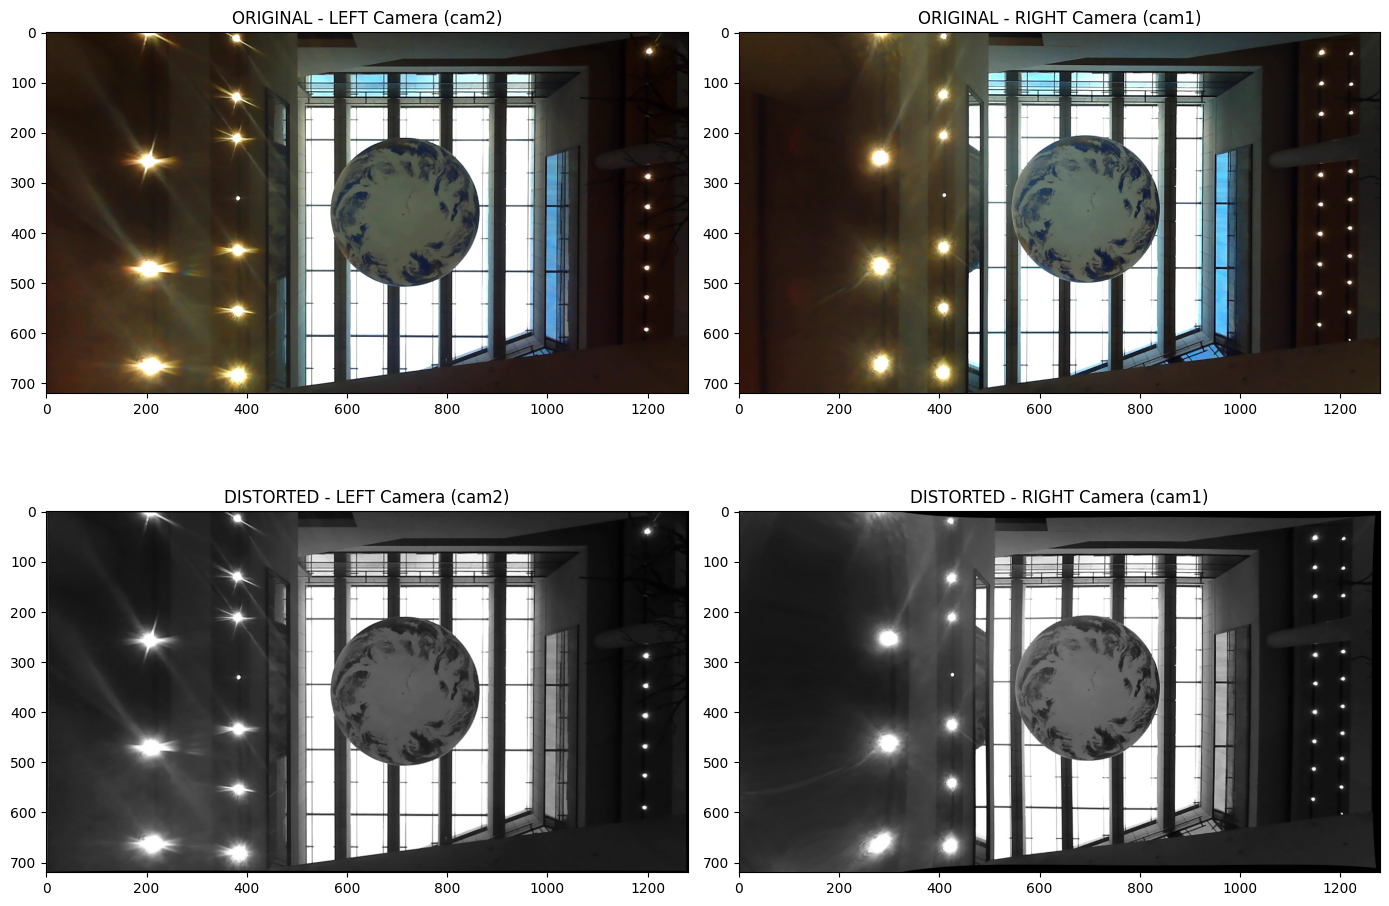

Original: (720, 1280)
Resized: (252, 448)
Using f_pixel = 374.3807025
Computing Disparity Done: 1.7019940000000133 sec

===== Disparity Info =====
estDisp shape: (252, 368)
estDisp min/max: 0.00 / 79.00
estDisp mean: 29.70
estDisp median: 24.00
Number of zeros: 13078

===== ROI Coordinates =====
Scaled ROI: y[87:157], x[227:262]
Median disparity in ROI: 29.00
Estimated Depth: 19.468m
Real Depth: 20m
Error: 0.532m


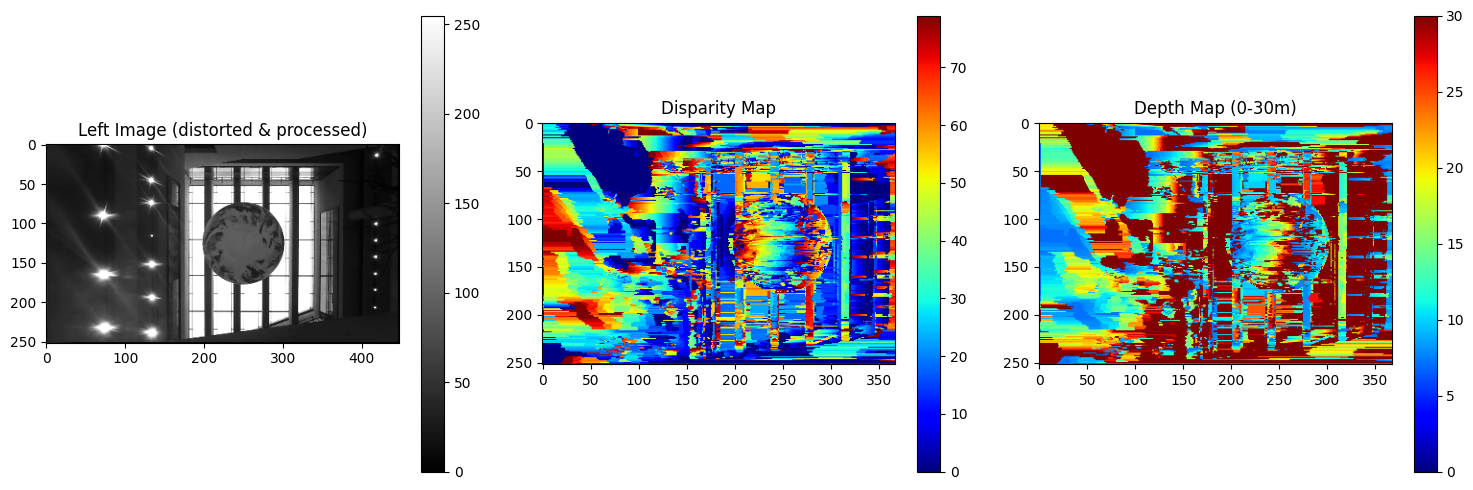

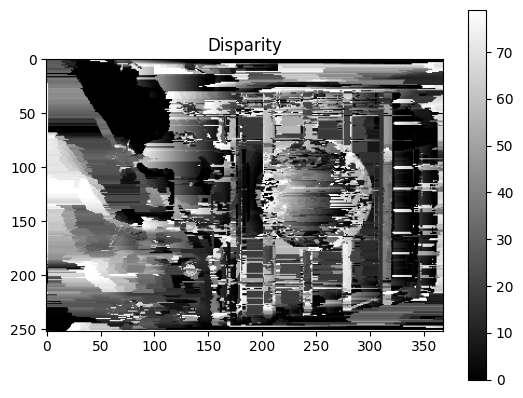

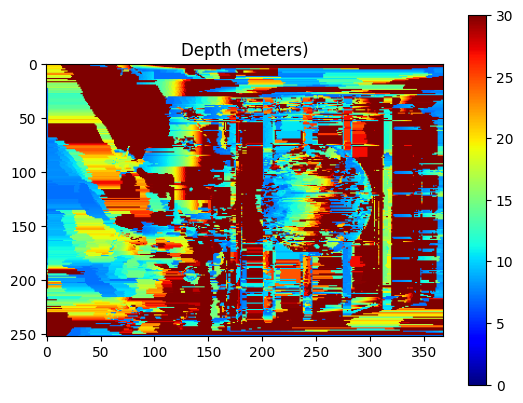

In [27]:
#WORK GEH VERSION 2c


import numpy as np 
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import math
import cv2
plt.close('all')



def dynamicProgramVec(unaryCosts, pairwiseCosts):
    
    # count number of positions (i.e. pixels in the scanline), and nodes at each
    # position (i.e. the number of distinct possible disparities at each position)
    nNodesPerPosition = len(unaryCosts)
    nPosition = len(unaryCosts[0])

    # define minimum cost matrix - each element will eventually contain
    # the minimum cost to reach this node from the left hand side.
    # We will update it as we move from left to right
    minimumCost = np.zeros([nNodesPerPosition, nPosition])

    # TODO: fill this function in. (hint use tiling and perform calculations columnwise with matricies)

    parents = np.zeros([nNodesPerPosition, nPosition])

    unaryCosts = np.array(unaryCosts)
    pairwiseCosts = np.array(pairwiseCosts)

    minimumCost[:, 0] = unaryCosts[:, 0]

    for c in range(1, nPosition):

        prev = minimumCost[:, c-1].reshape(-1, 1)        
        transitionCost = prev + pairwiseCosts           

        minCost = np.min(transitionCost, axis=0)        
        minInd  = np.argmin(transitionCost, axis=0)     

        minimumCost[:, c] = unaryCosts[:, c] + minCost
        parents[:, c] = minInd

    bestPath = np.zeros(nPosition, dtype=int)

    bestPath[-1] = np.argmin(minimumCost[:, -1])
    parent = bestPath[-1]

    for c in range(nPosition-2, -1, -1):
        bestPath[c] = parents[parent, c+1]
        parent = bestPath[c]

    return bestPath


def apply_distortion(img, camera_matrix, dist_coeffs):
    """
    Apply distortion to an image based on camera parameters
    """
    h, w = img.shape[:2]
    
    # Create map for distortion
    map_x = np.zeros((h, w), dtype=np.float32)
    map_y = np.zeros((h, w), dtype=np.float32)
    
    # Camera parameters
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    cx = camera_matrix[0, 2]
    cy = camera_matrix[1, 2]
    
    k1, k2, p1, p2, k3 = dist_coeffs[0], dist_coeffs[1], dist_coeffs[2], dist_coeffs[3], dist_coeffs[4]
    
    print(f"Applying distortion with k1={k1:.4f}, k2={k2:.4f}")
    
    # For each pixel in the output (distorted) image
    for v in range(h):
        for u in range(w):
            # Normalize coordinates
            x = (u - cx) / fx
            y = (v - cy) / fy
            
            # Calculate r^2
            r2 = x*x + y*y
            r4 = r2 * r2
            r6 = r4 * r2
            
            # Radial distortion
            radial = 1 + k1*r2 + k2*r4 + k3*r6
            
            # Tangential distortion
            dx = 2*p1*x*y + p2*(r2 + 2*x*x)
            dy = p1*(r2 + 2*y*y) + 2*p2*x*y
            
            # Apply distortion
            x_distorted = x * radial + dx
            y_distorted = y * radial + dy
            
            # Convert back to pixel coordinates
            map_x[v, u] = x_distorted * fx + cx
            map_y[v, u] = y_distorted * fy + cy
    
    # Apply the distortion mapping
    distorted_img = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    
    return distorted_img


# Camera 1 Intrinsics from your MATLAB output
camera_matrix_1 = np.array([
    [1054.9526, 0, 825.8235],
    [0, 1041.7461, 351.6964],
    [0, 0, 1]
], dtype=np.float32)

# Radial distortion for Camera 1: [k1, k2, p1, p2, k3]
dist_coeffs_1 = np.array([0.4745, -1.3516, 0, 0, 0], dtype=np.float32)

# Camera 2 Intrinsics from your MATLAB output
camera_matrix_2 = np.array([
    [1084.3657, 0, 695.6607],
    [0, 1086.9103, 347.2030],
    [0, 0, 1]
], dtype=np.float32)

# Radial distortion for Camera 2: [k1, k2, p1, p2, k3]
dist_coeffs_2 = np.array([0.0565, -0.1061, 0, 0, 0], dtype=np.float32)


# Load images
left_img_path = "./Dataset_25/task_2/2c_00_cam2.jpg"
right_img_path = "./Dataset_25/task_2/2c_00_cam1.jpg"

im1_color = cv2.imread(left_img_path)
im2_color = cv2.imread(right_img_path)
im1_original = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
im2_original = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)

if im1_original is None or im2_original is None:
    raise FileNotFoundError("Images not found")

# ===== APPLY DISTORTION HERE =====
print("\n===== Applying Distortion =====")
print("Distorting Camera 2 (left image)...")
im1_distorted = apply_distortion(im1_original, camera_matrix_2, dist_coeffs_2)

print("Distorting Camera 1 (right image)...")
im2_distorted = apply_distortion(im2_original, camera_matrix_1, dist_coeffs_1)

# Save distorted images
cv2.imwrite('distorted_cam2_left.jpg', im1_distorted)
cv2.imwrite('distorted_cam1_right.jpg', im2_distorted)

# ===== DIAGNOSTIC CHECK: Show original vs distorted images =====
print("\n===== Camera Setup Check =====")
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(im1_color, cv2.COLOR_BGR2RGB))
plt.title('ORIGINAL - LEFT Camera (cam2)')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(im2_color, cv2.COLOR_BGR2RGB))
plt.title('ORIGINAL - RIGHT Camera (cam1)')

plt.subplot(2, 2, 3)
plt.imshow(im1_distorted, cmap='gray')
plt.title('DISTORTED - LEFT Camera (cam2)')

plt.subplot(2, 2, 4)
plt.imshow(im2_distorted, cmap='gray')
plt.title('DISTORTED - RIGHT Camera (cam1)')

plt.tight_layout()
plt.show()



# Use distorted images for stereo matching
im1 = im1_distorted
im2 = im2_distorted

# Convert to float
im1 = im1.astype(np.float32)
im2 = im2.astype(np.float32)

print("Original:", im1.shape)

# downsample, because DP stereo cannot run full resolution
scale = 0.35
im1 = cv2.resize(im1, (0,0), fx=scale, fy=scale)
im2 = cv2.resize(im2, (0,0), fx=scale, fy=scale)

imY, imX = im1.shape
print("Resized:", im1.shape)
f_pixel = (1054.9526+1084.3657)/2*scale
#f_pixel = 1084 * scale         
baseline = 1.508              

print("Using f_pixel =", f_pixel)

maxDisp = 80
alpha = 1
noiseSD = 8

pairwiseCosts = alpha*np.ones([maxDisp, maxDisp]) - alpha*np.eye(maxDisp)
estDisp = np.zeros([imY, imX - maxDisp])

start = time.perf_counter()
for y in range(imY):
    unary = np.zeros([maxDisp, imX - maxDisp])
    for d in range(maxDisp):
        diff = im1[y, :imX-maxDisp] - im2[y, d:d+(imX-maxDisp)]
        unary[d, :] = (diff*diff) / (2*noiseSD*noiseSD)
    estDisp[y, :] = dynamicProgramVec(unary, pairwiseCosts)

print("Computing Disparity Done:", time.perf_counter()-start, "sec")

print("\n===== Disparity Info =====")
print(f"estDisp shape: {estDisp.shape}")
print(f"estDisp min/max: {estDisp.min():.2f} / {estDisp.max():.2f}")
print(f"estDisp mean: {np.mean(estDisp):.2f}")
print(f"estDisp median: {np.median(estDisp):.2f}")
print(f"Number of zeros: {np.sum(estDisp == 0)}")

depth = (f_pixel * baseline) / (estDisp + 1e-6)
real_depth = 20

# Region around the bottle (adjust manually after viewing images)
y1, y2 = int(250*scale), min(int(450*scale), estDisp.shape[0])
x1, x2 = int(650*scale), min(int(750*scale), estDisp.shape[1])

print(f"\n===== ROI Coordinates =====")
print(f"Scaled ROI: y[{y1}:{y2}], x[{x1}:{x2}]")
roi_disparity = estDisp[y1:y2, x1:x2]

valid_disparities = roi_disparity

median_disparity = np.median(valid_disparities)
estimated_depth = (f_pixel * baseline) / median_disparity
print(f"Median disparity in ROI: {median_disparity:.2f}")
print(f"Estimated Depth: {estimated_depth:.3f}m")
print(f"Real Depth: {real_depth}m")
print(f"Error: {abs(estimated_depth - real_depth):.3f}m")



# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(im1, cmap='gray')
plt.title('Left Image (distorted & processed)')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(estDisp, cmap='jet')
plt.title('Disparity Map')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(depth, cmap='jet', vmin=0, vmax=30)
plt.title('Depth Map (0-30m)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Individual plots
plt.figure()
plt.imshow(estDisp, cmap="gray")
plt.colorbar()
plt.title("Disparity")
plt.show()

plt.figure()
plt.imshow(depth, cmap='jet', vmin=0, vmax=30)
plt.colorbar()
plt.title("Depth (meters)")
plt.show()